# SDoH Extraction using LLMs

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from pathlib import Path
import sys
from IPython.display import display, HTML

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

### Loading the models

In [3]:
import torch
import transformers

# Use shared cache
os.environ['HF_HOME'] = '/data/resource/huggingface'
os.environ['TRANSFORMERS_OFFLINE'] = '1'  # Force offline mode

# What models are available
cache_dir = "/data/resource/huggingface/hub"
available_models = []

if os.path.exists(cache_dir):
    for item in os.listdir(cache_dir):
        if item.startswith("models--"):
            # Convert models--org--name to org/name format
            model_name = item.replace("models--", "").replace("--", "/")
            available_models.append(model_name)

print("Available cached models:")
for model in sorted(available_models):
    print(f"  {model}")

/opt/anaconda/envs/keble8263-sdoh-extraction/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Available cached models:
  CohereForAI/aya-23-35B
  CohereForAI/aya-23-8B
  CohereForAI/aya-vision-8b
  HuggingFaceTB/SmolLM-135M-Instruct
  LLaMAX/LLaMAX3-8B-Alpaca
  Qwen/Qwen2.5-1.5B
  Qwen/Qwen2.5-3B
  Qwen/Qwen2.5-72B-Instruct
  Qwen/Qwen2.5-7B
  Qwen/Qwen2.5-7B-Instruct
  Qwen/Qwen2.5-7B-instruct
  Qwen/Qwen2.5-VL-7B-Instruct
  Qwen/Qwen3-0.6B
  Qwen/Qwen3-8B
  Unbabel/wmt20-comet-qe-da
  Unbabel/wmt22-comet-da
  bert-base-uncased
  bert-large-uncased
  cardiffnlp/twitter-roberta-base-sentiment
  clairebarale/refugee_cases_ner
  deepseek-ai/DeepSeek-R1-Distill-Llama-70B
  deepseek-ai/DeepSeek-R1-Distill-Llama-8B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-14B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-32B
  deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
  facebook/nllb-200-3.3B
  facebook/nllb-200-distilled-1.3B
  facebook/nllb-200-distilled-600M
  google/gemma-3-1b-it
  google/gemma-3-27b-it
  google/gemma-3-27b-it-qat-q4_0-gguf
  gpt2
  gpt2-medium
  gpt2-xl
  hfl/chinese-electra-180g-small-di

In [4]:
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Transformers version: 4.52.3
PyTorch version: 2.6.0
CUDA available: True


## 1. Few-shot extraction of SDoH from one note

In [5]:
# Load cleaned data
brc_referrals_cleaned = pd.read_csv("../data/processed/BRC_referrals_cleaned.csv")

# Load a specific note: Case Reference = CAS-467812
sample_note = brc_referrals_cleaned[brc_referrals_cleaned['Case Reference'] == 'CAS-467812'].iloc[0]['Referral Notes (depersonalised)']

print("Sample Note:")
print(sample_note)

Sample Note:
Befriending. Lives with husband for whom patient is carer. Living on ready meals at present. PERSON concerned that they may not be eating / drinking enough. Carers in XXXX times daily for patient to help with washing / dressing. Depending on side - effects of radiotherapy , patient may go on to PEG feeding. Patient feeling slightly overwhelmed by everything. FPOC and Carers Support Shropshire numbers given to patient ’s daughter ( with patient consent ) but would value additional emotional support / befriending / check ins to make sure they are eating / drinking etc as all activities of daily living severely compromised at present. Very supportive daughter who lives in PERSON. The patient is due to start radiotherapy on XXXX January so support during this time would be particularly beneficial. Due to start radiotherapy on XXXX at SATH EOS XXXX.


### Defining the classification task

I define a similar classification task as Guevara et al. (2024). I also added 4 of the 21 SDoH used in Keloth et al. (2025)

**Task**: Multi-label sentence-level classification

**SDoH**: 10 SDoH categories

Guevara et al. (2024) & Keloth et al. (2025):
- Employment status 
- Housing issues 
- Transportation issues 
- Parental status
- Relationship status
- Social support
- Substance use

Keloth et al. (2025)
- Financial issues
- Education level 
- Food insecurity

I define two levels of classification, similarly to the papers cited above:

1. Level 1: *Any SDoH mentions*. The presence of language describing an SDoH category as defined above, regardless of the attribute. 
2. Level 2: *Adverse SDoH mentions*. The presence or absence of language describing an SDoH category with an attribute that could create an additional social work or resource support need for patients:
    - Employment status: unemployed, underemployed, disability
    - Housing issue: financial status, undomiciled, other
    - Transportation issue: distance, resources, other
    - Parental status: having a child under 18 years old
    - Relationship: widowed, divorced, single
    - Social support: absence of social support
    - Substance use: alcohol abuse, drug use, smoking
    - Financial issues: poverty, debt, inability to pay bills, benefit dependency
    - Education level: low education, illiteracy, lack of qualifications
    - Food insecurity: hunger, inability to afford food, reliance on food banks, poor nutrition

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel
import json
import re
from typing import List, Dict

from utils.model_helpers import load_instruction_model
from utils.SDoH_classification_helpers import SDoHExtractor

# Load one of the instruction-tuned models
# Qwen/Qwen2.5-7B-Instruct - Excellent for zero-shot classification
# meta-llama/Llama-3.1-8B-Instruct - Very capable instruction-following model
# microsoft/Phi-4-mini-instruct - Smaller but efficient
# mistralai/Mistral-7B-Instruct-v0.3 - Great performance on classification tasks

In [25]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer, model = None, None

tokenizer, model = load_instruction_model(model_name)

Loading Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Qwen/Qwen2.5-7B-Instruct loaded successfully!


In [26]:
from utils.prompt_creation_helpers import create_automated_prompt

prompt_example_basic = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=1)
print("=" * 50)
print("Example Prompt (Five Shot Basic):")
print("=" * 50)
print(prompt_example_basic)

prompt_example_detailed = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=1)
print("=" * 50)
print("Example Prompt (Five Shot Detailed):")
print("=" * 50)
print(prompt_example_detailed)

prompt_example_basic_lvl2 = create_automated_prompt("This is a sentence", tokenizer=tokenizer, prompt_type="five_shot_basic", level=2)
print("=" * 50)
print("Example Prompt (Five Shot Basic - Level 2):")
print("=" * 50)
print(prompt_example_basic_lvl2)

Using chat template for qwen/qwen2.5-7b-instruct
Example Prompt (Five Shot Basic):
<|im_start|>system
You are analyzing a referral note sentence to identify mentions of Social Determinants of Health (SDoH).

Given a sentence, output all SDoH factors that can be inferred from that sentence from the following list: 
EmploymentStatus, Housing, Transportation, ParentalStatus, RelationshipStatus, SocialSupport, SubstanceUse, FinancialSituation, EducationLevel, FoodInsecurity. 

If the sentence does NOT mention any of the above categories, output <LIST>NoSDoH</LIST>.

Your response must be a comma-separated list of SDoH factors embedded with <LIST> and </LIST>.

**STRICT RULES**: 
- DO NOT generate any other text, explanations, or new SDoH labels.
- A sentence CAN be labeled with one or more SDoH factors.
- Your response must ONLY contain the <LIST>...</LIST> format.
- Do not continue or complete the input sentence.

EXAMPLES:
Input: "Person is unemployed and lives with his elderly mother."


In [27]:
# Initialize the SDoH extractor
extractor_lvl1 = SDoHExtractor(
    model=model,
    tokenizer=tokenizer,
    prompt_type="five_shot_detailed",
    level=1,
    debug=True,
)

# Extract SDoH factors
results_lvl1 = extractor_lvl1.extract_from_note(sample_note)
results_lvl1_df = extractor_lvl1.results_to_dataframe(results_lvl1, note_id="sample")

print("\nExtracted SDoH Factors (Level 1):")
display(results_lvl1_df)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Using chat template for qwen/qwen2.5-7b-instruct

Extracted SDoH Factors (Level 1):


,note_id,sentence_number,sentence,has_sdoh,sdoh_factors,num_sdoh_factors
0,sample,1,Lives with husband for whom patient is carer,False,NoSDoH,0
1,sample,2,Living on ready meals at present,False,NoSDoH,0
2,sample,3,[PERSON] concerned that they may not be eating...,False,NoSDoH,0
3,sample,4,Carers in [REDACTED] times daily for patient t...,False,NoSDoH,0
4,sample,5,"Depending on side - effects of radiotherapy , ...",False,NoSDoH,0
5,sample,6,Patient feeling slightly overwhelmed by everyt...,False,NoSDoH,0
6,sample,7,FPOC and Carers Support Shropshire numbers giv...,False,NoSDoH,0
7,sample,8,Very supportive daughter who lives in [PERSON],False,NoSDoH,0
8,sample,9,The patient is due to start radiotherapy on [R...,False,NoSDoH,0
9,sample,10,Due to start radiotherapy on [REDACTED] at SAT...,False,NoSDoH,0


In [28]:
# Some debugging
print("Prompt: \n")
print(results_lvl1['sentences'][1]['debug']['prompt'])

print("Raw response: \n")
print(results_lvl1['sentences'][1]['debug']['raw_response'])

Prompt: 

<|im_start|>system
You are analyzing a referral note sentence to identify mentions of Social Determinants of Health (SDoH).

Given a sentence, output all SDoH factors that can be inferred from that sentence from the following list: 
EmploymentStatus, Housing, Transportation, ParentalStatus, RelationshipStatus, SocialSupport, SubstanceUse, FinancialSituation, EducationLevel, FoodInsecurity. 

If the sentence does NOT mention any of the above categories, output <LIST>NoSDoH</LIST>.

Your response must be a comma-separated list of SDoH factors embedded with <LIST> and </LIST>.

**STRICT RULES**: 
- DO NOT generate any other text, explanations, or new SDoH labels.
- A sentence CAN be labeled with one or more SDoH factors.
- Your response must ONLY contain the <LIST>...</LIST> format.
- Do not continue or complete the input sentence.
Below are detailed guidelines:

EmploymentStatus: Annotate sentences that describe a person's work situation, including current employment, unemploym

In [12]:
# Initialize the SDoH extractor
extractor_lvl2 = SDoHExtractor(
    model=model,
    tokenizer=tokenizer,
    prompt_type="five_shot_basic",
    level=2,
    debug=True,
)

# Extract SDoH factors
results_lvl2 = extractor_lvl2.extract_from_note(sample_note)
results_lvl2_df = extractor_lvl2.results_to_dataframe(results_lvl2, note_id="sample")

print("\nExtracted SDoH Factors (Level 2):")
display(results_lvl2_df)


Extracted SDoH Factors (Level 2):


,note_id,sentence_number,sentence,has_sdoh,sdoh_factors,num_sdoh_factors
0,sample,1,Lives with husband for whom patient is carer,True,"RelationshipStatus-Protective, Housing-Protective",2
1,sample,2,Living on ready meals at present,True,FoodInsecurity-Adverse,1
2,sample,3,[PERSON] concerned that they may not be eating...,True,FoodInsecurity-Advers,1
3,sample,4,Carers in [REDACTED] times daily for patient t...,True,SocialSupport-Protective,1
4,sample,5,"Depending on side - effects of radiotherapy , ...",True,Housing-NoSDoH,1
5,sample,6,Patient feeling slightly overwhelmed by everyt...,False,NoSDoH,0
6,sample,7,FPOC and Carers Support Shropshire numbers giv...,True,"Race/Ethnicity-Adverse, SocialSupport-Protective",2
7,sample,8,Very supportive daughter who lives in [PERSON],True,SocialSupport-Protective,1
8,sample,9,The patient is due to start radiotherapy on [R...,True,SocialSupport-Protective,1
9,sample,10,Due to start radiotherapy on [REDACTED] at SAT...,False,NoSDoH,0


## 2. Few-shot classification of SDoH across notes

The following script processes a batch of notes, based on the SDoH extractor used for a single note earlier. It includes many options that can be modified:

- model name
- prompt type
- level of classification (1 for mention of SDoH, 2 for adverse vs. protective mention)
- batch size and start index


To run it, enter the following command in the terminal, after activating the conda environment and adjusting the options:

```console
python scripts/batch_process_notes.py --model_name "meta-llama/Llama-3.1-8B-Instruct" \
                                 --prompt_type "five_shot_basic" \
                                 --level 1 \
                                 --batch_size 10 \
                                 --start_index 0
```

In [19]:
# Read batch result csv
batch_results_path = "../results/batch_results/Llama_3.1_8B_Instruct_five_shot_basic_L1_0-9.csv"

batch_results_df = pd.read_csv(batch_results_path)

### Consistency in few-shot classification across models and prompts (level 1) 

Found 32 CSV files
Combined dataset: 2800 rows
Loaded data: 350 sentences, 8 model-prompt combinations
Visualisation saved as 'model_consistency_analysis.png'


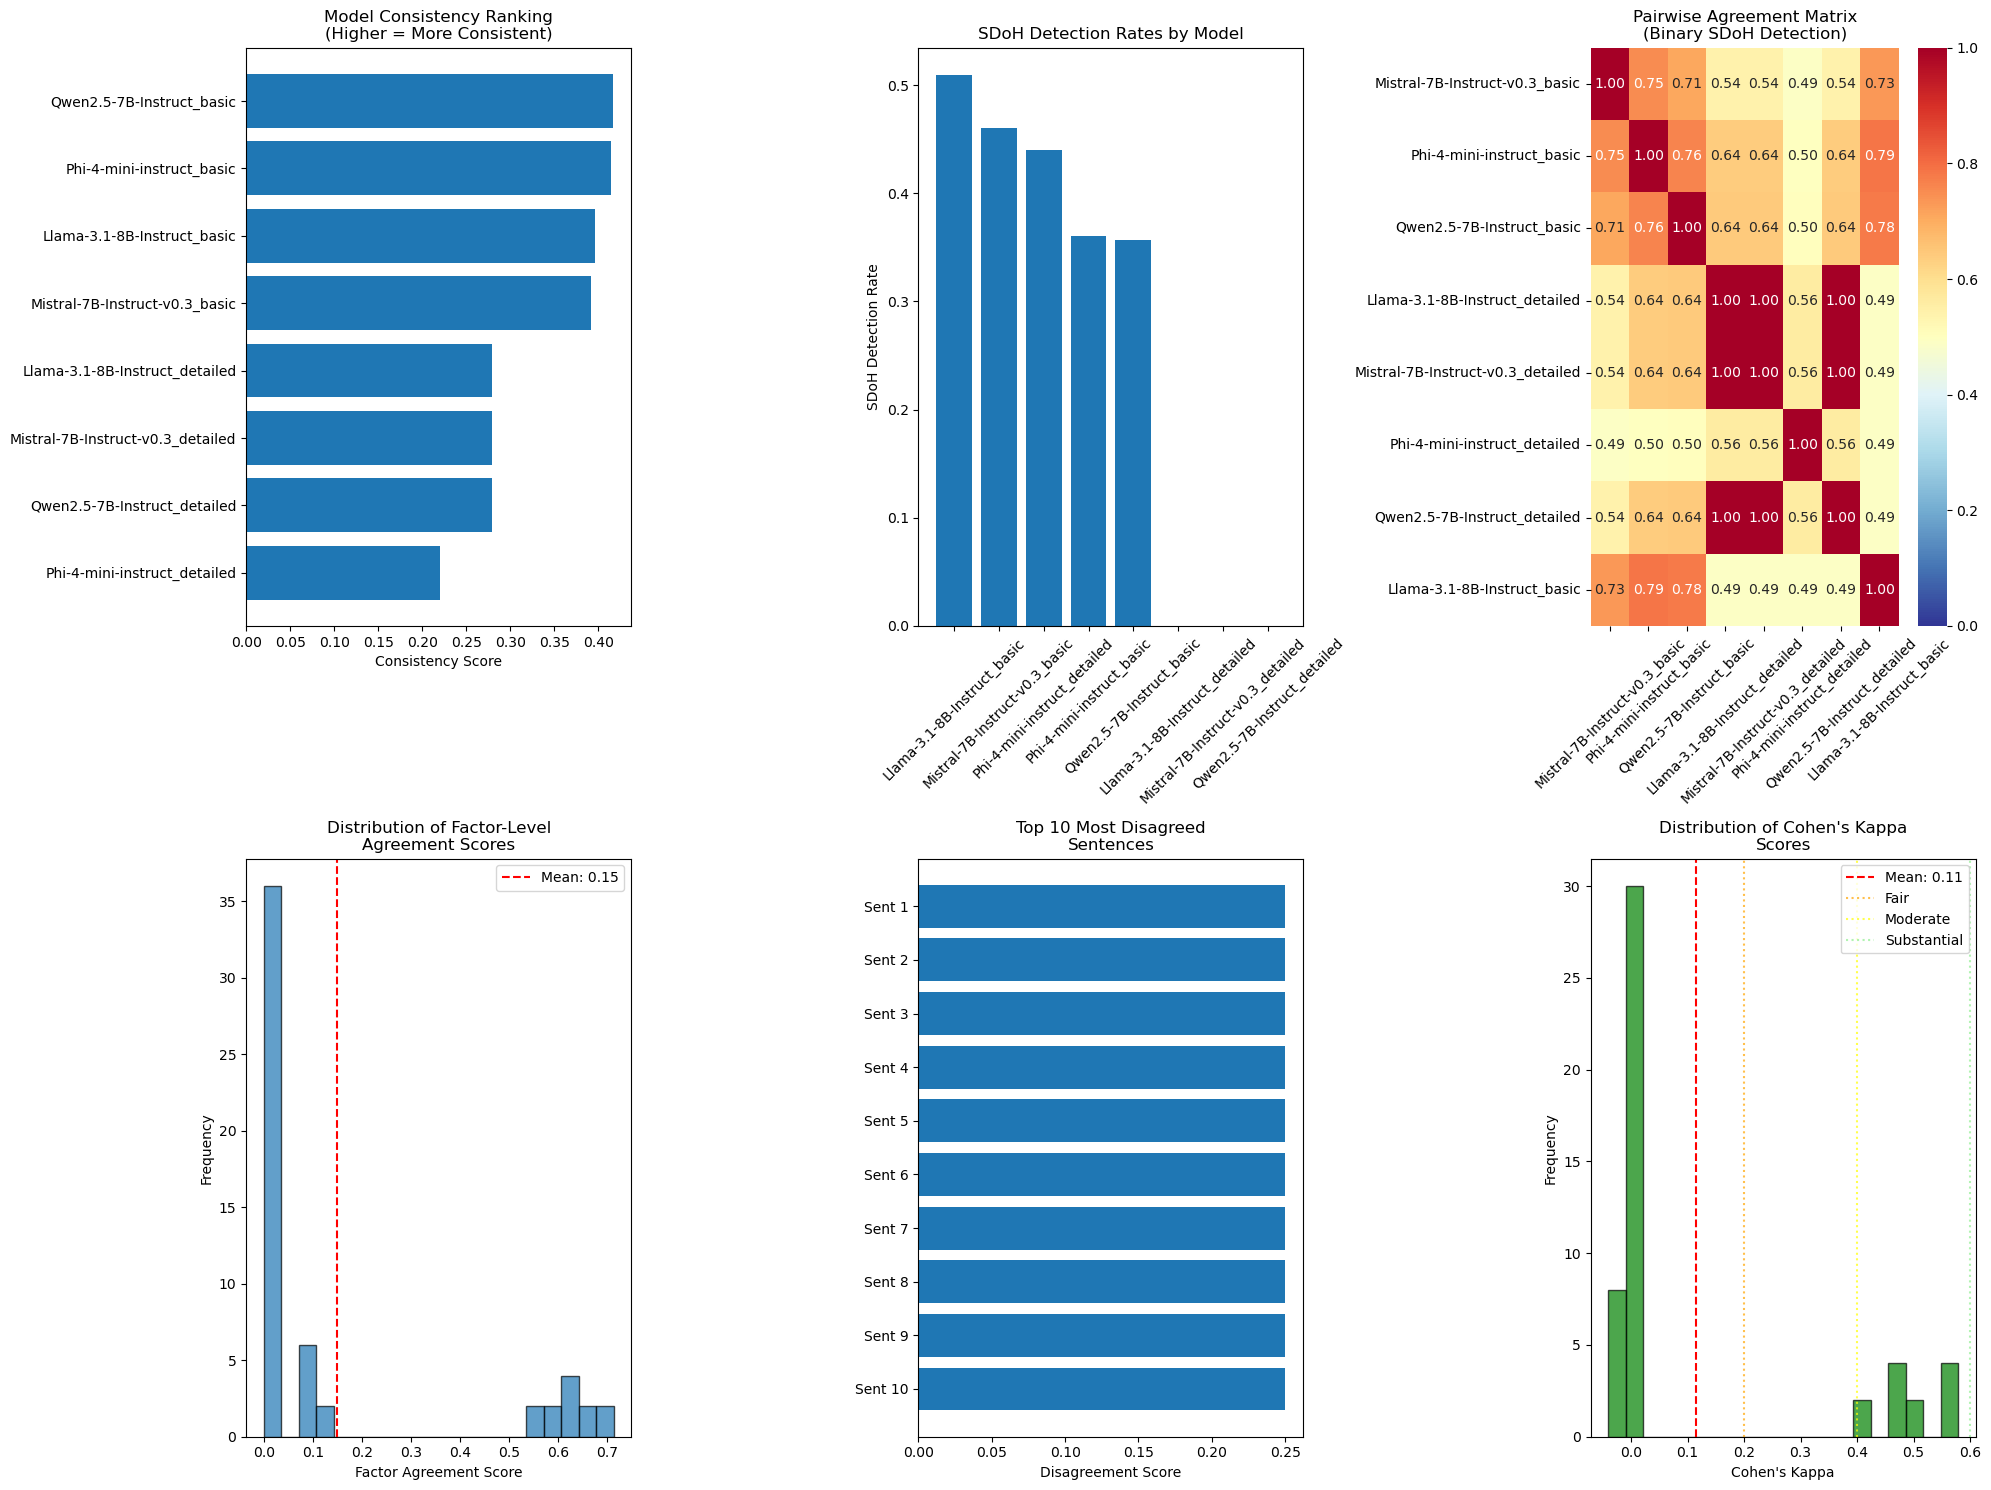

                                         model  avg_sentence_agreement  \
2          Qwen2.5-7B-Instruct_five_shot_basic                0.668571   
1          Phi-4-mini-instruct_five_shot_basic                0.674286   
7        Llama-3.1-8B-Instruct_five_shot_basic                0.609796   
0     Mistral-7B-Instruct-v0.3_five_shot_basic                0.614694   
3     Llama-3.1-8B-Instruct_five_shot_detailed                0.696327   
4  Mistral-7B-Instruct-v0.3_five_shot_detailed                0.696327   
6       Qwen2.5-7B-Instruct_five_shot_detailed                0.696327   
5       Phi-4-mini-instruct_five_shot_detailed                0.522449   

   avg_factor_agreement  avg_cohen_kappa  consistency_score  num_comparisons  
2              0.294371         0.202089           0.416367               14  
1              0.265898         0.216346           0.414387               14  
7              0.280239         0.227936           0.396371               14  
0              0.

In [23]:
from utils.batch_analysing_helpers import load_and_analyse_consistency

# Load and analyze all CSV files
# This batch consists of results from the classification of the 200 first notes across: 
# - 4 models (Llama-3.1-8B-Instruct, Qwen2.5-7B-Instruct, Phi-4-mini-instruct, Mistral-7B-Instruct-v0.3)
# - 2 prompt types (five_shot_basic, five_shot_detailed)
consistency_analyser = load_and_analyse_consistency("../results/batch_results/comparison_batch_07_06")

# Generate visualisations
consistency_analyser.visualise_consistency(save_plots=True)

# Get consistency ranking
ranking = consistency_analyser.model_consistency_ranking()
print(ranking)

# Generate detailed report
report = consistency_analyser.generate_report()
print(report)

# Save report
with open('consistency_report.txt', 'w') as f:
    f.write(report)